# Building a Regression Model for a Financial Dataset

In this notebook, you will build a simple linear regression model to predict the closing AAPL stock price. The lab objectives are:
* Pull data from the Yahoo Finance library into a Pandas dataframe
* Use Matplotlib to visualize data
* Use Scikit-Learn to build a regression model

In [33]:
import yfinance as yf

# Specify the ticker symbol and desired timeframe
ticker = "AAPL"  # Replace with the desired ticker
start_date = "2004-01-01"
end_date = "2024-09-09"

# Download historical data
data = yf.download(ticker, start=start_date, end=end_date)
data = data.reset_index()
# Save data to CSV file
#data.to_csv("AAPL_data.csv")
print(type(data))
data.dropna(inplace=True)
data.head()
data.shape

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>


(5205, 7)

In [34]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rc('figure', figsize=(12, 8.0))

## Create three day trend
This operation creates a new column where each row holds the closing price from 1 day before. It’s useful for calculating changes in price, trends, or lagging values, as it allows you to easily compare today’s close price with the close price from the previous day.

The only features you'll use as input into the model are the previous day's closing price and a three day trend value. The trend value can only take on two values, either -1 or +1. If the AAPL stock price has increased over any two of the previous three days then the trend will be +1. Otherwise, the trend value will be -1.


In [35]:

import numpy as np

# Load your data into a DataFrame (adjust as needed)
df = data

# Create lagged columns
df['min_1_close'] = df['Close'].shift(1)
df['min_2_close'] = df['Close'].shift(2)
df['min_3_close'] = df['Close'].shift(3)
df['min_4_close'] = df['Close'].shift(4)

# Calculate trends
df['min_1_trend'] = np.where(df['min_1_close'] - df['min_2_close'] > 0, 1, -1)
df['min_2_trend'] = np.where(df['min_2_close'] - df['min_3_close'] > 0, 1, -1)
df['min_3_trend'] = np.where(df['min_3_close'] - df['min_4_close'] > 0, 1, -1)

# Calculate 3-day trend
df['trend_3_day'] = np.where(df['min_1_trend'] + df['min_2_trend'] + df['min_3_trend'] > 0, 1, -1)

# Create the final DataFrame for training data
train_data = df[['Date', 'Close', 'min_1_close', 'trend_3_day']].sort_values(by='Date', ascending=True)

# Display or save the final data
print(train_data.head())


        Date     Close  min_1_close  trend_3_day
0 2004-01-02  0.380000          NaN           -1
1 2004-01-05  0.395893     0.380000           -1
2 2004-01-06  0.394464     0.395893           -1
3 2004-01-07  0.403393     0.394464           -1
4 2004-01-08  0.417143     0.403393            1


View the first five rows of the query's output. Note that the object `df` containing the query output is a Pandas Dataframe.

In [36]:
print(type(df))
df.dropna(inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume,min_1_close,min_2_close,min_3_close,min_4_close,min_1_trend,min_2_trend,min_3_trend,trend_3_day
4,2004-01-08,0.407857,0.423750,0.404464,0.417143,0.352267,460303200,0.403393,0.394464,0.395893,0.380000,1,-1,1,1
5,2004-01-09,0.414821,0.430893,0.406964,0.410714,0.346838,427459200,0.417143,0.403393,0.394464,0.395893,1,1,-1,1
6,2004-01-12,0.415179,0.428571,0.412500,0.423750,0.357846,487547200,0.410714,0.417143,0.403393,0.394464,-1,1,1,1
7,2004-01-13,0.441071,0.443571,0.426071,0.430714,0.363727,679016800,0.423750,0.410714,0.417143,0.403393,1,-1,1,1
8,2004-01-14,0.435714,0.438214,0.424643,0.432143,0.364934,620043200,0.430714,0.423750,0.410714,0.417143,1,1,-1,1


## Visualize data

The simplest plot you can make is to show the closing stock price as a time series. Pandas DataFrames have built in plotting funtionality based on Matplotlib. 

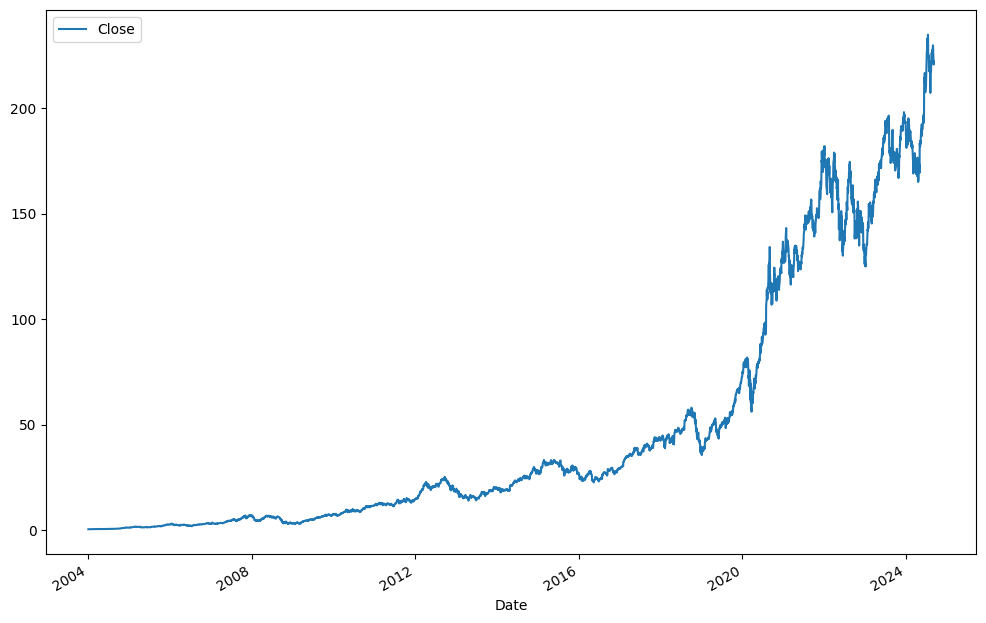

In [37]:
train_data.plot(x='Date', y='Close');

You can also embed the `trend_3_day` variable into the time series above. 

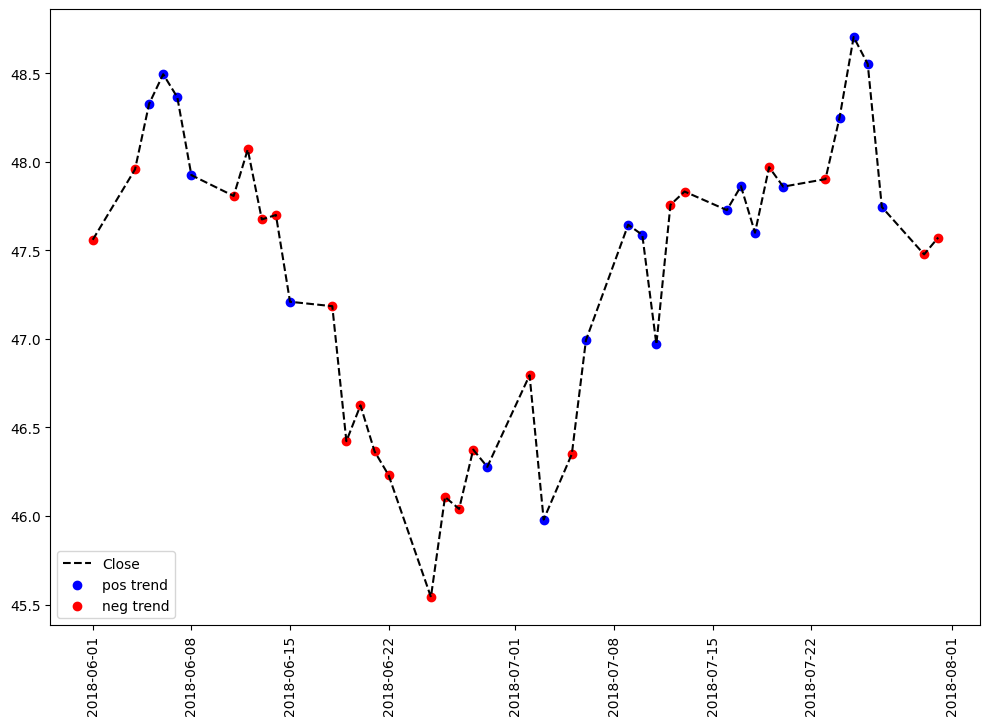

In [38]:
start_date = '2018-06-01'
end_date = '2018-07-31'

df = train_data

plt.plot(
    'Date', 'Close', 'k--',
    data = (
        df.loc[pd.to_datetime(df.Date).between(start_date, end_date)]
    )
)

plt.scatter(
    'Date', 'Close', color='b', label='pos trend', 
    data = (
        df.loc[df.trend_3_day == 1 & pd.to_datetime(df.Date).between(start_date, end_date)]
    )
)

plt.scatter(
    'Date', 'Close', color='r', label='neg trend',
    data = (
        df.loc[(df.trend_3_day == -1) & pd.to_datetime(df.Date).between(start_date, end_date)]
    )
)

plt.legend()
plt.xticks(rotation = 90);

In [39]:
df.shape

(5205, 4)

## Build a Regression Model in Scikit-Learn

In this section you'll train a linear regression model to predict AAPL closing prices when given the previous day's closing price `day_prev_close` and the three day trend `trend_3_day`. A training set and test set are created by sequentially splitting the data after 4000 rows. 

In [40]:
features = ['min_1_close', 'trend_3_day']
target = 'Close'

X_train, X_test = df.loc[1:4000, features], df.loc[4000:, features]
y_train, y_test = df.loc[1:4000, target], df.loc[4000:, target]

In [41]:
# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

In [42]:
# Train the model using the training set
regr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [43]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [44]:
# The mean squared error
print('Root Mean Squared Error: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

# Explained variance score: 1 is perfect prediction
print('Variance Score: {0:.2f}'.format(r2_score(y_test, y_pred)))

Root Mean Squared Error: 2.67
Variance Score: 1.00


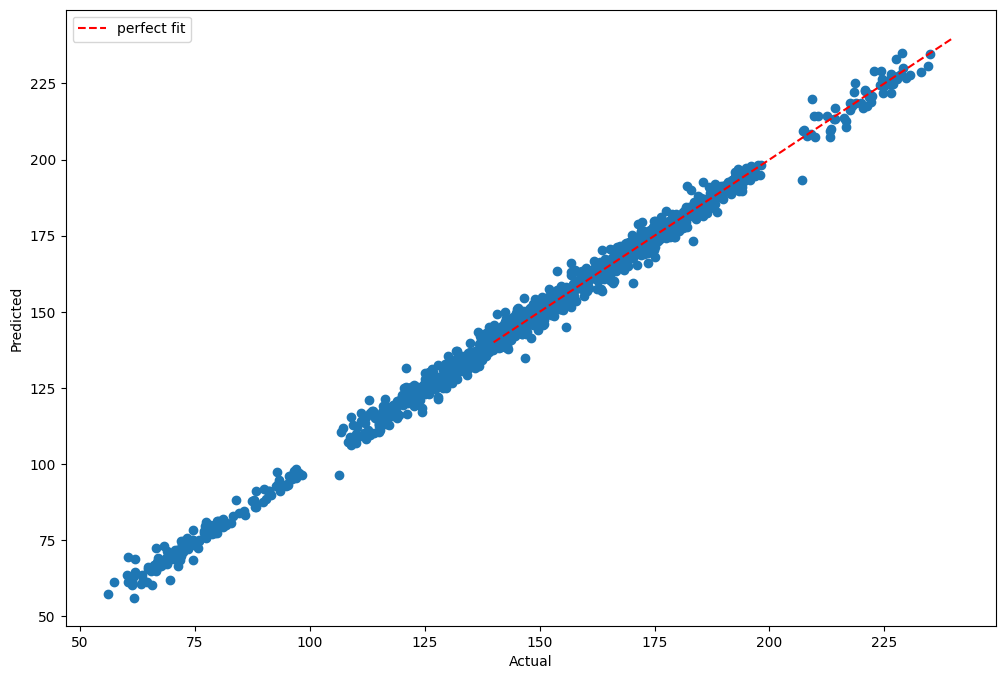

In [45]:
plt.scatter(y_test, y_pred)
plt.plot([140, 240], [140, 240], 'r--', label='perfect fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend();

The model's predictions are more or less in line with the truth. However, the utility of the model depends on the business context (i.e. you won't be making any money with this model). It's fair to question whether the variable `trend_3_day` even adds to the performance of the model:

In [46]:
print('Root Mean Squared Error: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, X_test.min_1_close))))

Root Mean Squared Error: 2.67


Indeed, the RMSE is actually lower if we simply use the previous day's closing value as a prediction! Does increasing the number of days included in the trend improve the model? Feel free to create new features and attempt to improve model performance!